In [238]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In [239]:
train = pd.read_csv('../input/train.tsv', sep = '\t', index_col=['train_id'])
test = pd.read_csv('../input/test.tsv', sep = '\t', index_col=['test_id'])

/opt/conda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [240]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1482535 entries, 0 to 1482534
Data columns (total 7 columns):
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 90.5+ MB


In [241]:
train.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
train_id,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [242]:
categories = train['category_name'].str.split('/', n = 2, expand=True)
train['category1'], train['category2'], train['category3'] = categories[0], categories[1], categories[2]

In [243]:
train.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category1,category2,category3
train_id,,,,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


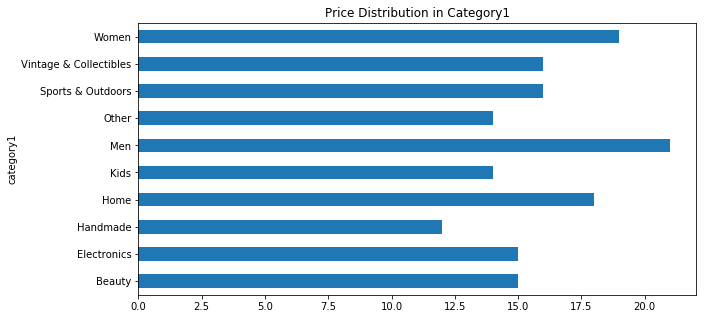

In [244]:
train.groupby('category1')['price'].median().plot(kind='barh', figsize = (10, 5), title = 'Price Distribution in Category1')

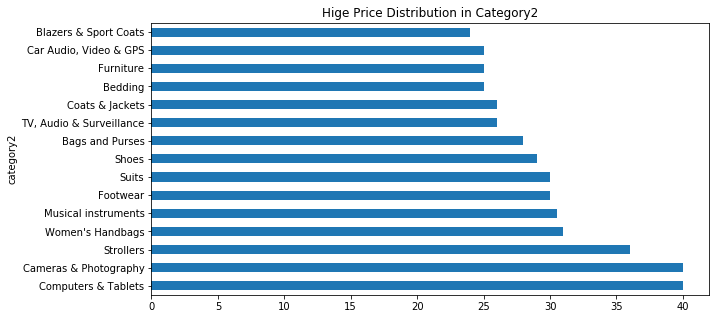

In [245]:
train.groupby('category2')['price'].median().sort_values(ascending=False)[:15].plot(kind='barh',  figsize = (10, 5), \
                                                                            title = 'Hige Price Distribution in Category2')

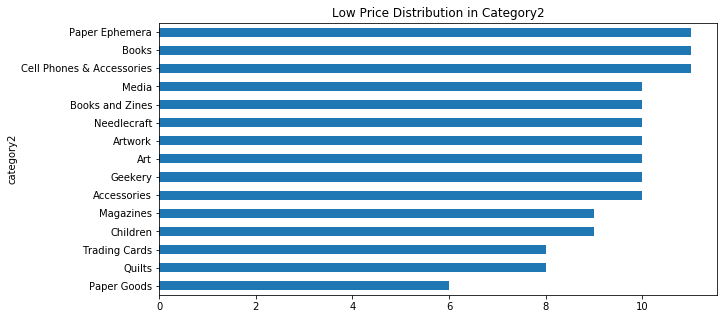

In [246]:
train.groupby('category2')['price'].median().sort_values()[:15].plot(kind='barh',  figsize = (10, 5), \
                                                                            title = 'Low Price Distribution in Category2')

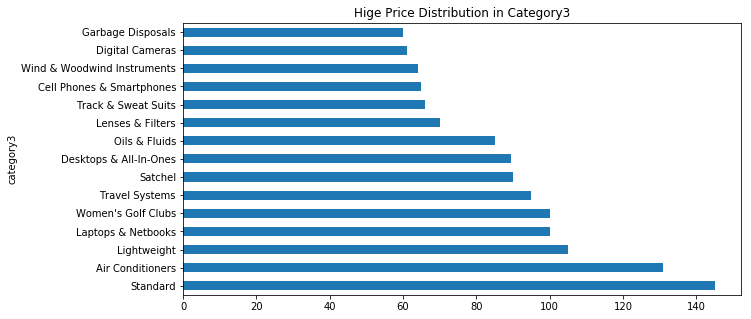

In [247]:
train.groupby('category3')['price'].median().sort_values(ascending=False)[:15].plot(kind='barh',  figsize = (10, 5), \
                                                                                    title = 'Hige Price Distribution in Category3')

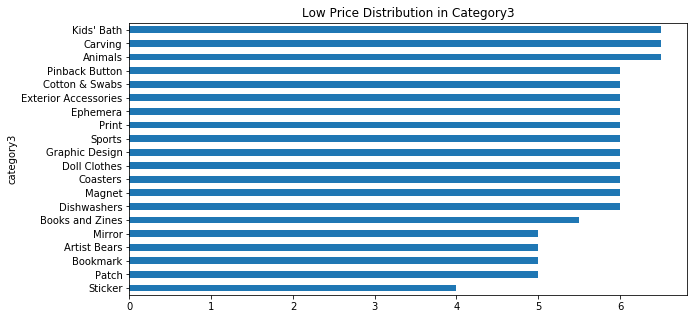

In [248]:
train.groupby('category3')['price'].median().sort_values()[:20].plot(kind='barh',  figsize = (10, 5), \
                                                                            title = 'Low Price Distribution in Category3')

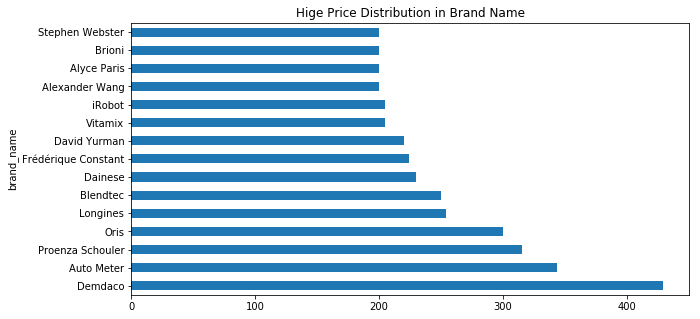

In [249]:
train.groupby('brand_name')['price'].median().sort_values(ascending=False)[:15].plot(kind='barh',  figsize = (10, 5), \
                                                                                    title = 'Hige Price Distribution in Brand Name')

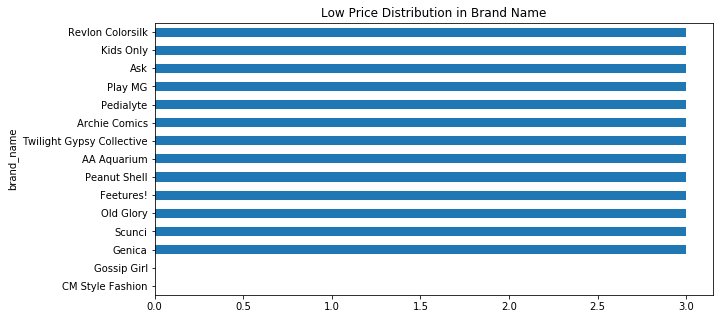

In [250]:
train.groupby('brand_name')['price'].median().sort_values()[:15].plot(kind='barh',  figsize = (10, 5), \
                                                                                    title = 'Low Price Distribution in Brand Name')

In [251]:
def high_low_price(groupby):
    groupby_median = train.groupby(groupby)['price'].median()
    high_price_99 = groupby_median.quantile(.99)
    low_price_01 = groupby_median.quantile(.01)
    high_price_cat = groupby_median[groupby_median > high_price_99].index.tolist()
    low_price_cat = groupby_median[groupby_median < low_price_01].index.tolist()
    return high_price_cat, low_price_cat
cat1_high, cat1_low = high_low_price('category1')
cat2_high, cat2_low = high_low_price('category2')
cat3_high, cat3_low = high_low_price('category3')
brand_high, brand_low = high_low_price('brand_name')

In [252]:
train['cat1_high'] = np.where(train['category1'].isin(cat1_high), 1, 0)
train['cat2_high'] = np.where(train['category2'].isin(cat2_high), 1, 0)
train['cat3_high'] = np.where(train['category3'].isin(cat3_high), 1, 0)
train['cat1_low'] = np.where(train['category1'].isin(cat1_low), 1, 0)
train['cat2_low'] = np.where(train['category2'].isin(cat2_low), 1, 0)
train['cat3_low'] = np.where(train['category3'].isin(cat3_low), 1, 0)
train['brand_high'] = np.where(train['brand_name'].isin(brand_high), 1, 0)
train['brand_low'] = np.where(train['brand_name'].isin(brand_low), 1, 0)

In [253]:
pop_brand = train['brand_name'].value_counts()[:50].index.tolist()
train['pop_brand'] = np.where(train['brand_name'].isin(pop_brand), 1, 0)

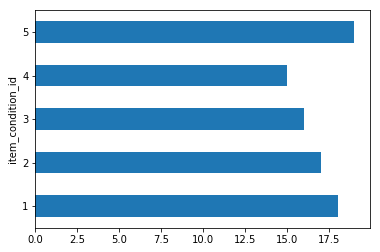

In [254]:
train.groupby('item_condition_id')['price'].median().plot(kind='barh')

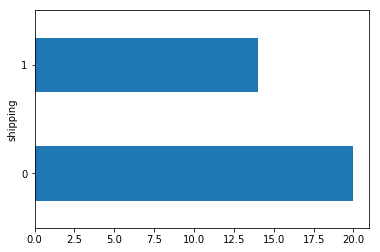

In [255]:
train.groupby('shipping')['price'].median().plot(kind='barh')

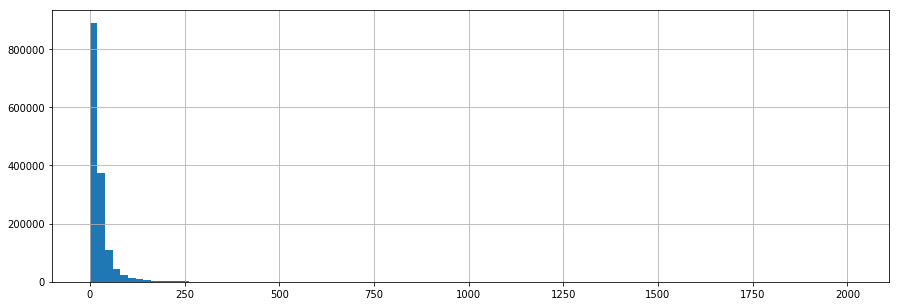

In [256]:
train['price'].hist(bins=100, figsize=(15,5))

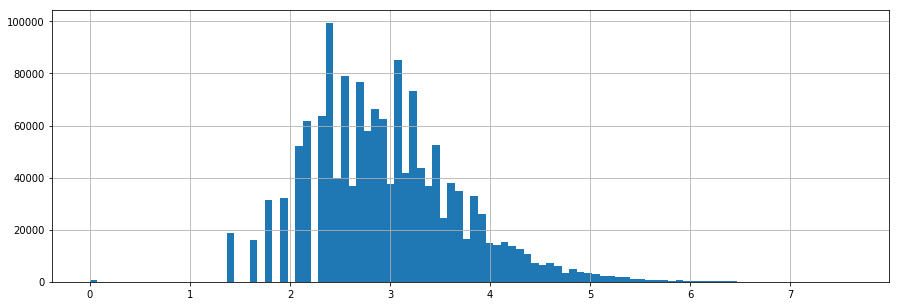

In [257]:
train['price'].apply(np.log1p).hist(bins=100, figsize=(15,5))

In [258]:
train_ = train.copy()
train_['price'] = train_['price'].apply(np.log1p)
train_.drop(['category_name'], axis=1, inplace=True)

In [259]:
train_.dropna(axis = 0, subset = ['item_description'], inplace=True)

In [260]:
train_['brand_name'].fillna('Unknown brand', inplace=True)

In [261]:
# sig_brand = train_['brand_name'].value_counts().index.tolist()[1:1001]
# train_.loc[train_['brand_name'].isin(sig_brand), 'brand_name'] = 'Unknown brand'

In [262]:
train_['category1'].fillna('Unknown category1', inplace=True)
train_['category2'].fillna('Unknown category2', inplace=True)
train_['category3'].fillna('Unknown category3', inplace=True)

In [263]:
# sig_cat2 = train_['category2'].value_counts().index.tolist()[:1000]
# sig_cat3 = train_['category3'].value_counts().index.tolist()[:1000]
# train_.loc[~train_['category2'].isin(sig_brand), 'category2'] = 'Unknown category2'
# train_.loc[~train_['category3'].isin(sig_brand), 'category3'] = 'Unknown category3'

In [264]:
from sklearn.model_selection import train_test_split
y = train_['price']
X = train_.drop(['price'], axis=1)
strat = (y/2).apply(np.ceil)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=strat)

In [265]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

count_name = CountVectorizer(min_df = 10)
X_train_name = count_name.fit_transform(X_train['name'])
X_test_name = count_name.transform(X_test['name'])

In [266]:
count_category1, count_category2, count_category3 = CountVectorizer(), CountVectorizer(), CountVectorizer()
X_train_cat1 = count_category1.fit_transform(X_train['category1'])
X_test_cat1 = count_category1.transform(X_test['category1'])
X_train_cat2 = count_category2.fit_transform(X_train['category2'])
X_test_cat2 = count_category2.transform(X_test['category2'])
X_train_cat3 = count_category3.fit_transform(X_train['category3'])
X_test_cat3 = count_category3.transform(X_test['category3'])

In [267]:
import re

def preprocess(text):
    text = re.sub('(\d{2})\s?(gb?)', '\\1\\2', text, flags=re.IGNORECASE).upper()
    return text

In [268]:

count_des = TfidfVectorizer(max_features=50000, ngram_range=(1,3), stop_words='english', \
                           preprocessor = preprocess)
X_train_dec = count_des.fit_transform(X_train['item_description'])

In [269]:
X_test_dec = count_des.transform(X_test['item_description'])

In [270]:
brand_label = LabelBinarizer(sparse_output=True)
X_train_brand = brand_label.fit_transform(X_train['brand_name'])
X_test_brand = brand_label.transform(X_test['brand_name'])

In [271]:
from scipy import sparse
other_col = ['cat1_high','cat2_high', 'cat3_high', 'cat1_low', 'cat2_low', 'cat3_low',
       'brand_high', 'brand_low', 'pop_brand']
X_train_other = sparse.csr_matrix(np.c_[pd.get_dummies(X_train[['item_condition_id', 'shipping']]), 
                                        X_train[other_col]])
X_test_other = sparse.csr_matrix(np.c_[pd.get_dummies(X_test[['item_condition_id', 'shipping']]), 
                                        X_test[other_col]])


In [272]:
X_train_ = sparse.hstack((X_train_name, X_train_cat1, X_train_cat2, \
                          X_train_cat3, X_train_dec, X_train_brand, X_train_other)).tocsr()
X_test_ = sparse.hstack((X_test_name, X_test_cat1, X_test_cat2, \
                          X_test_cat3, X_test_dec, X_test_brand, X_test_other)).tocsr()

In [273]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_log_error

In [274]:
ridge = Ridge(solver='sag', random_state = 0)
ridge.fit(X_train_, y_train)
ridge_pred = ridge.predict(X_train_)

In [275]:
mean_squared_log_error(np.exp(y_train), np.exp(ridge_pred))

0.17666374228515763

In [276]:
ridge_test = ridge.predict(X_test_)
mean_squared_log_error(np.exp(y_test), np.exp(ridge_test))

0.19656250621486931

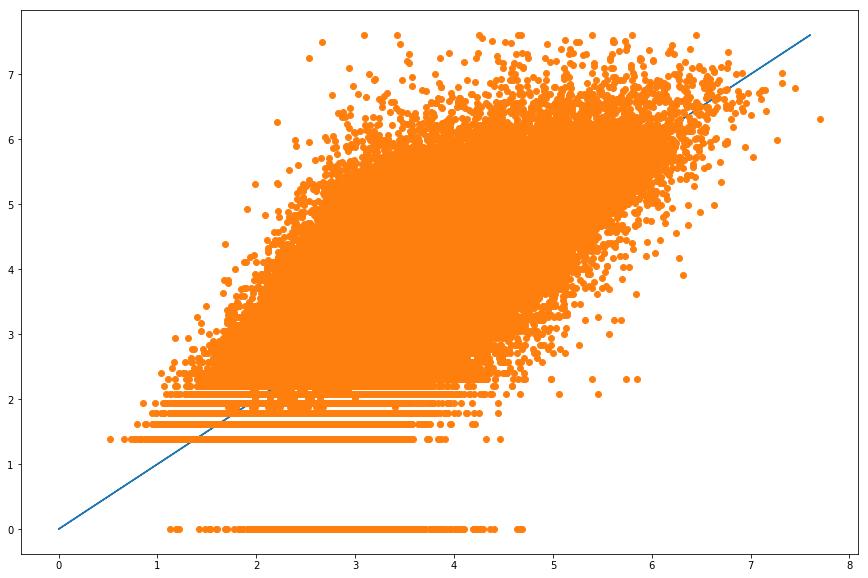

In [277]:
plt.figure(figsize=(15,10))
plt.plot(y_train, y_train, ridge_pred, y_train, 'o')

In [278]:
mean_squared_log_error(y_train, ridge_pred)

0.013166939569904118

In [279]:
X_row = X_train_.shape[0]

In [280]:
features = count_name.get_feature_names() + count_category1.get_feature_names() + \
count_category2.get_feature_names() + count_category3.get_feature_names() + count_des.get_feature_names()\
+ list(brand_label.classes_) + other_col


In [281]:
feature_coef = zip(features, np.abs(ridge.coef_))
sorted(feature_coef, key = lambda tup: tup[1], reverse=True)

[('LIMBS', 2.3299909184972054),
 ('CARAT', 2.1224850096515762),
 ('500GB', 2.0916681855233858),
 ('14K', 2.0317008737898306),
 ('I5', 1.9303572253899686),
 ('128GB', 1.8993298151290861),
 ('64GB', 1.8356963907540349),
 ('dockatot', 1.7848999803362391),
 ('heuer', 1.7567411276774543),
 ('32GB 64GB', 1.7337174738671008),
 ('tria', 1.7162484373082716),
 ('APPLE WATCH BAND', 1.7071741410401671),
 ('IN POP', 1.7029365370565697),
 ('sonos', 1.6906063329444432),
 ('16GB 32GB', 1.6508854723292807),
 ('GOLD FINISHED', 1.6483830582133729),
 ('UNLOCKED', 1.6300024891831577),
 ('16GB', 1.5795462809203418),
 ('IPOD CLASSIC', 1.5731667694909888),
 ('JORDAN SUPREME', 1.5537861400567519),
 ('tyme', 1.5508209331409641),
 ('007taz', 1.5441715320678091),
 ('owlet', 1.5224270243244742),
 ('hatchimals', 1.5213439184886002),
 ('dyson', 1.5126695372143386),
 ('hatchimal', 1.5046053915237048),
 ('tieks', 1.4946314229455908),
 ('saudi', 1.4800009793967071),
 ('dji', 1.4646503349472124),
 ('FOR FITBIT', 1.45666